In [1]:
# --- Import Libraries ---------------------------------------------------------
library(ggplot2)
library(ggdist)
library(patchwork)
library(dplyr)
library(Cairo)
library(glmmTMB)
library(lmerTest)
library(emmeans)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step


Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



In [ ]:
# --- Load Data ------------------------------------------------------------------
data <- read.csv("data/fullResults.csv", header = TRUE)

# Create binary anchor and alignment labels
data <- data %>%
  mutate(
    anchor = ifelse(anchorCategory == "anchor", "anchor", "non-anchor"),
    alignment = ifelse(alignmentCategory == "aligned", "aligned", "unaligned")
  )

# Create anchorType (special anchors 25 and 50)
data <- data %>%
  mutate(anchorType = case_when(
    selectedPart == 25 ~ "25",
    selectedPart == 50 ~ "50",
    TRUE ~ "non-anchor"
  ))

# Factorize main grouping variables
data$alignment <- factor(data$alignment, levels = c("aligned", "unaligned"))
data$anchor <- factor(data$anchor, levels = c("anchor", "non-anchor"))
data$chartType <- factor(data$chartType, levels = c("pie", "line"))
# Relabel factor levels for pretty plotting
levels(data$alignment) <- c("Aligned", "Unaligned")
levels(data$anchor) <- c("Anchor", "Non-Anchor")
levels(data$chartType) <- c("Pie", "Stacked Bar")

# Create numeric contrast-coded variables for modeling
data <- data %>%
  mutate(
    alignment_num = ifelse(alignment == "Aligned", -1, 1),
    anchor_num = ifelse(anchor == "Anchor", -1, 1),
    chartType_num = ifelse(chartType == "Pie", -1, 1)
  )

# Factorize detailed categories (alignmentCategory, anchorCategory)
data$alignmentCategory <- factor(data$alignmentCategory, levels = c("aligned", "near-aligned", "far-from-aligned"))
levels(data$alignmentCategory) <- c("Aligned", "Near Aligned", "Far from Aligned")

data$anchorCategory <- factor(data$anchorCategory, levels = c("anchor", "near-anchor", "far-anchor"))
levels(data$anchorCategory) <- c("Anchor", "Near Anchor", "Far from Anchor")

# Calculate rounding variables
data$distToNearest5 <- abs(data$selectedPart - round(data$selectedPart / 5) * 5)
data$distToNearest10 <- abs(data$selectedPart - round(data$selectedPart / 10) * 10)

In [3]:
# --- Define Constants ---------------------------------------------------------
blue <- "#336199"
lightblue <- "#5688C7"
red <- "#E74236"
lightred <- "#EE766D"
green <- "#00A35F"
lightgreen <- "#0ACC7B"

lisAbsError <- c(0, 10)
size <- 0.5
baseSize <- 28
timeLims = c(0, 10)
errorLims = c(0, 5)

breaksAbsError <- seq(floor(min(data$absError)) - 0.5, ceiling(max(data$absError)) + 0.5, by = 1)

In [7]:
# --- Build Accuracy Model --------------------------------------------------------------
modelAccuracy <- glmmTMB(
  absError ~ chartType_num * anchor_num * alignment_num + distToNearest10 +
    (1 + anchor_num + alignment_num + chartType_num + distToNearest10 | userID),
  data = data,
  family = nbinom2(link = "log")
)

In [5]:
# --- Build Speed Model --------------------------------------------------------------
modelSpeed <- glmmTMB(
  responseTime ~ chartType_num * anchor_num * alignment_num +
    (1 + anchor_num + alignment_num + chartType_num | userID),
  data = data,
  family = Gamma(link = "log")
)
summary(modelSpeed)

 Family: Gamma  ( log )
Formula:          
responseTime ~ chartType_num * anchor_num * alignment_num + (1 +  
    anchor_num + alignment_num + chartType_num | userID)
Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
  27055.1   27181.1  -13508.5   27017.1      5593 

Random effects:

Conditional model:
 Groups Name          Variance  Std.Dev. Corr              
 userID (Intercept)   0.1248288 0.35331                    
        anchor_num    0.0019921 0.04463   0.12             
        alignment_num 0.0007469 0.02733   0.31 -0.44       
        chartType_num 0.0033118 0.05755   0.16  0.35  0.04 
Number of obs: 5612, groups:  userID, 60

Dispersion estimate for Gamma family (sigma^2): 0.147 

Conditional model:
                                         Estimate Std. Error z value Pr(>|z|)
(Intercept)                             1.8728939  0.0463525   40.41  < 2e-16
chartType_num                           0.0008645  0.0110938    0.08  0.93788
anchor_num                     

In [8]:
# --- Predict from Model -------------------------------------------------------
predsAccuracy <- as.data.frame(emmeans(modelAccuracy, ~ alignment_num * anchor_num * chartType_num))
predsSpeed <- as.data.frame(emmeans(modelSpeed, ~ alignment_num * anchor_num * chartType_num))

In [10]:
make_plot <- function(data, preds_df, chart_type, xvar, xlims, adjust_val = 1.5) {
  preds_df <- preds_df %>%
    mutate(
      alignment = ifelse(alignment_num == -1, "Aligned", "Unaligned"),
      anchor = ifelse(anchor_num == -1, "Anchor", "Non-Anchor"),
      chartType = ifelse(chartType_num == -1, "Pie", "Stacked Bar")
    )
  
  # Filter data and predictions
  plot_data <- data %>% filter(chartType == chart_type)
  preds_data <- preds_df %>% filter(chartType == chart_type)
  
  # Choose raw-data slab type
  slab_layer <- if (xvar == "absError") {
    stat_gradientinterval(
      breaks = breaksAbsError,
      slab_alpha = 0,
      point_alpha = 0,
      interval_alpha = 0,
      color = green,
      fill = lightgreen,
      height = 0.95
    )
  } else {
    stat_gradientinterval(
      slab_alpha = 1,
      point_size = 3,
      point_alpha = 0,
      interval_alpha = 0,
      color = green,
      fill = lightgreen,
      adjust = adjust_val,
      height = 0.95,
      fill_type = "gradient"
    )
  }
  
  # Build plot
  p <- ggplot(
    plot_data,
    aes(
      y = interaction(alignment, anchor, sep = " + "),
      x = .data[[xvar]]
    )
  ) +
    slab_layer +
    geom_segment(
      data = preds_data,
      aes(
        y = interaction(alignment, anchor, sep = " + "),
        yend = interaction(alignment, anchor, sep = " + "),
        x = exp(asymp.LCL),
        xend = exp(asymp.UCL)
      ),
      color = green,
      linewidth = 2,
      inherit.aes = FALSE
    ) +
    geom_line(
      data = preds_data,
      aes(
        y = interaction(alignment, anchor, sep = " + "),
        x = exp(emmean),
        group = 1
      ),
      color = green,
      linewidth = 1.5,
      inherit.aes = FALSE
    ) +
    theme_minimal(base_size = baseSize) +
    coord_cartesian(xlim = xlims) +
    scale_y_discrete(expand = expansion(mult = c(0, 0))) +
    labs(
      y = NULL,
      x = ifelse(xvar == "absError", "Absolute Error", "Response Time (s)")
    )
  
  # Only adjust axis ticks if absError
  if (xvar == "absError") {
    p <- p + scale_x_continuous(breaks = c(0, 1, 2, 3, 4, 5))  # only label 0, 5, 10
  }
  
  return(p)
}

Warning message in bandwidth_dpi():
“Bandwidth calculation failed.
→ Falling back to `bandwidth_nrd0()`.
ℹ This often occurs when a sample contains many duplicates, which suggests that
  a dotplot (e.g., `geom_dots()`) or histogram (e.g., `density_histogram()`,
  `stat_slab(density = 'histogram')`, or `stat_histinterval()`) may better
  represent the data.
Caused by error in `bw.SJ()`:
! sample is too sparse to find TD”
Warning message in draw_slabs(self, ...):
“`fill_type = "gradient"` is not supported by the current graphics device.
ℹ Falling back to `fill_type = "segments"`.
→ If you believe your current graphics device does support `fill_type =
  "gradient"` but auto-detection failed, try setting `fill_type = "gradient"`
  explicitly. If this causes the gradient to display correctly, then this
  warning is likely a false positive caused by the graphics device failing to
  properly report its support for the `"LinearGradient"` pattern via
  `grDevices::dev.capabilities()`. Consider 

pdf 
  2

Warning message in bandwidth_dpi():
“Bandwidth calculation failed.
→ Falling back to `bandwidth_nrd0()`.
ℹ This often occurs when a sample contains many duplicates, which suggests that
  a dotplot (e.g., `geom_dots()`) or histogram (e.g., `density_histogram()`,
  `stat_slab(density = 'histogram')`, or `stat_histinterval()`) may better
  represent the data.
Caused by error in `bw.SJ()`:
! sample is too sparse to find TD”
Warning message in bandwidth_dpi():
“Bandwidth calculation failed.
→ Falling back to `bandwidth_nrd0()`.
ℹ This often occurs when a sample contains many duplicates, which suggests that
  a dotplot (e.g., `geom_dots()`) or histogram (e.g., `density_histogram()`,
  `stat_slab(density = 'histogram')`, or `stat_histinterval()`) may better
  represent the data.
Caused by error in `bw.SJ()`:
! sample is too sparse to find TD”


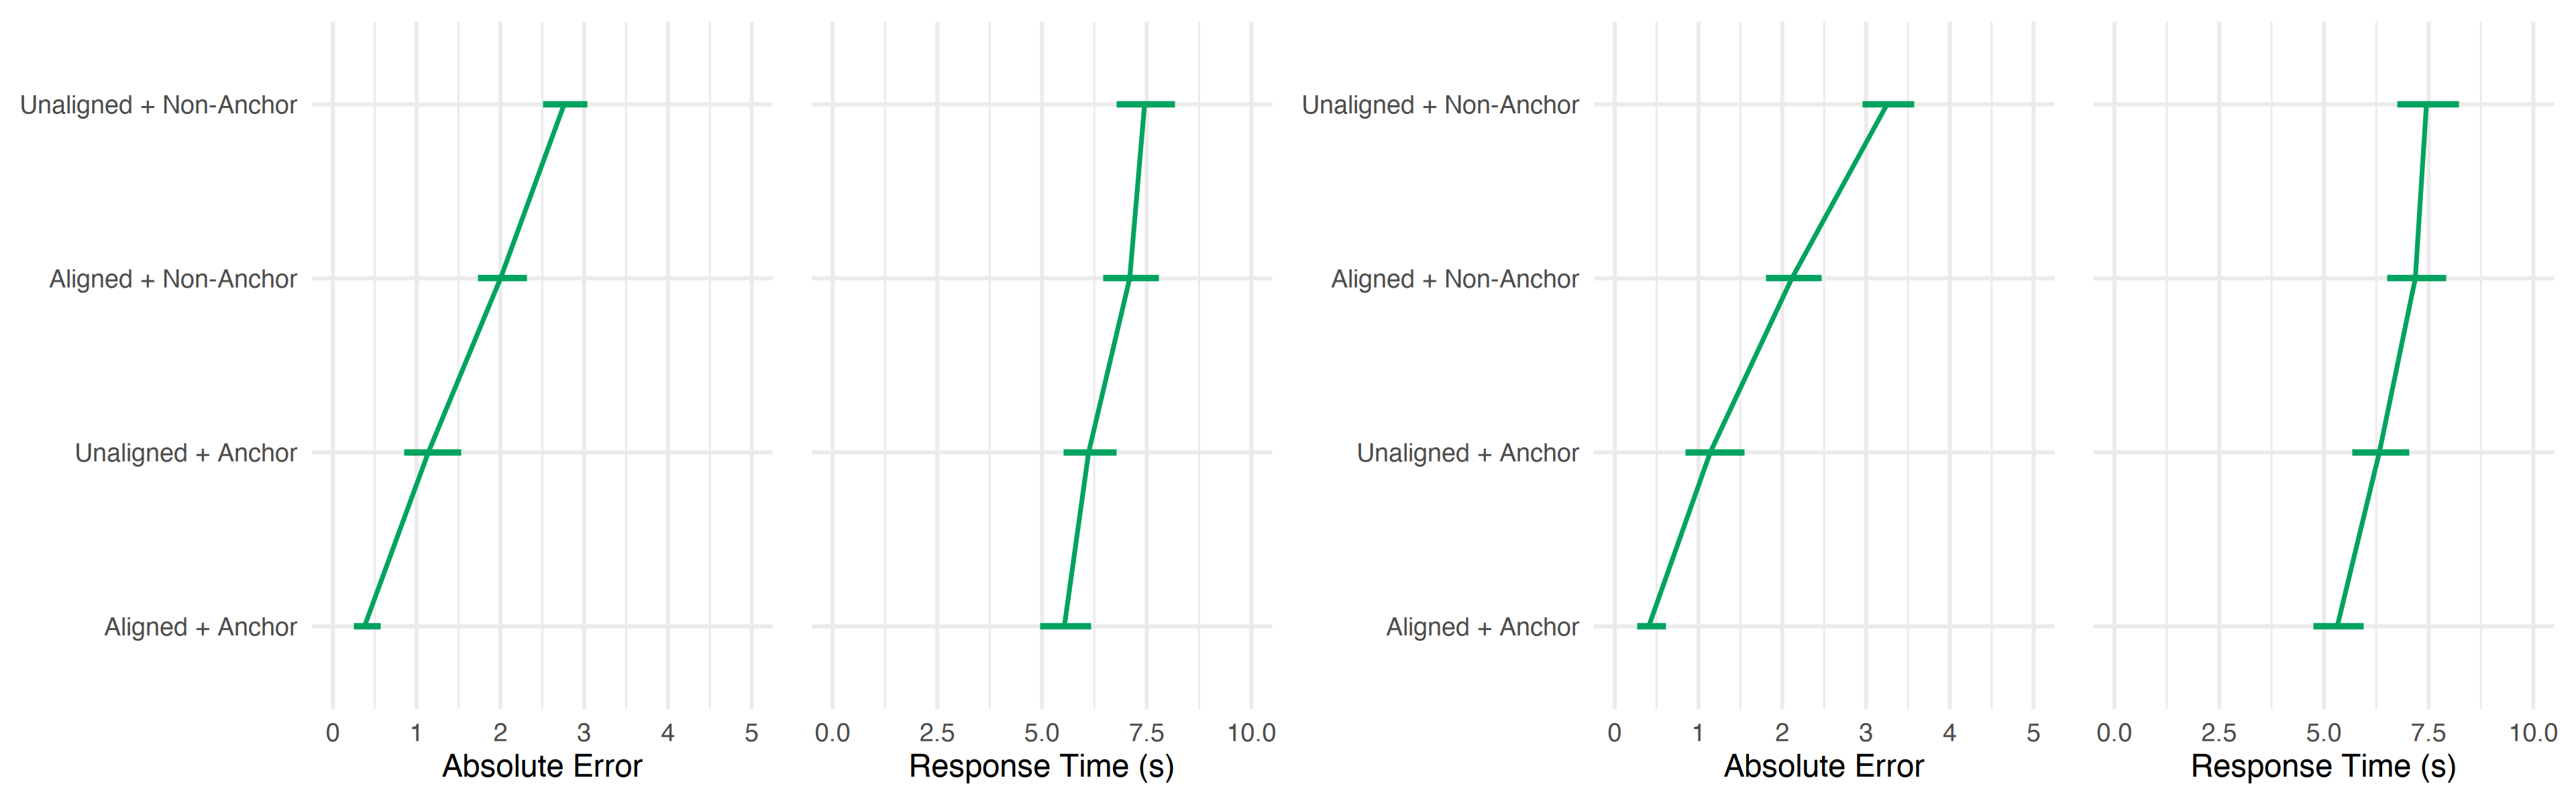

In [11]:
width <- 32
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

accuracyPie <- make_plot(data, predsAccuracy, chart_type = "Pie", xvar = "absError", xlims = errorLims)
speedPie    <- make_plot(data, predsSpeed, chart_type = "Pie", xvar = "responseTime", xlims = timeLims)
accuracyLine <- make_plot(data, predsAccuracy, chart_type = "Stacked Bar", xvar = "absError", xlims = errorLims)
speedLine    <- make_plot(data, predsSpeed, chart_type = "Stacked Bar", xvar = "responseTime", xlims = timeLims)

speedPie <- speedPie + theme(
  axis.title.y = element_blank(),
  axis.text.y = element_blank(),
  axis.ticks.y = element_blank()
)
speedLine <- speedLine + theme(
  axis.title.y = element_blank(),
  axis.text.y = element_blank(),
  axis.ticks.y = element_blank()
)

# Build your full plot
full_plot <- accuracyPie + speedPie + accuracyLine + speedLine +
  plot_layout(guides = "collect", ncol = 4)

# Open SVG device
Cairo::CairoSVG("teaserSimple.svg", width = width, height = height)

# Draw plot
print(full_plot)

# Close device
dev.off()
full_plot

In [13]:
# --- Build Accuracy Model --------------------------------------------------------------
modelAccuracy <- glmmTMB(
  absError ~ chartType_num * anchorCategory * alignmentCategory +
    (1 + anchorCategory + alignmentCategory + chartType_num | userID),
  data = data,
  family = nbinom2(link = "log")
)
summary(modelAccuracy)

Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')”
Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; singular convergence (7). See vignette('troubleshooting'), help('diagnose')”


 Family: nbinom2  ( log )
Formula:          
absError ~ chartType_num * anchorCategory * alignmentCategory +  
    (1 + anchorCategory + alignmentCategory + chartType_num |          userID)
Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
       NA        NA        NA        NA      5572 

Random effects:

Conditional model:
 Groups Name                              Variance Std.Dev. Corr             
 userID (Intercept)                       1.28847  1.1351                    
        anchorCategoryNear Anchor         0.41899  0.6473   -0.91            
        anchorCategoryFar from Anchor     0.65103  0.8069   -0.96  0.97      
        alignmentCategoryNear Aligned     0.02739  0.1655   -0.85  0.61  0.75
        alignmentCategoryFar from Aligned 0.10903  0.3302   -0.60  0.31  0.44
        chartType_num                     0.01948  0.1396    0.25 -0.24 -0.22
             
             
             
             
             
  0.90       
 -0.39 -0.33 
Number of obs: 